<a href="https://colab.research.google.com/github/arafatro/Recommender-Sys/blob/main/02%20Collaborative_filtering_recommenders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Collaborative filtering recommenders - overview and implementation</h1>

**In this lab, we'll be implementing a Memory-based collaborative filtering model, and go through the main differences both conceptually and in implementation between the user and item-based methods.**

## Collaborative Filtering Recommendation Model

Collaborative filtering is the most common technique when it comes to recommender systems. As its name suggests, it is a technique that helps filter out items for a user in a collaborative way, that is, based on the preferences of similar users.

Say Lizzy has just watched "Arrival" and "Blade Runner 2049", and now wants to be recommended some similar movies, because she loved these.

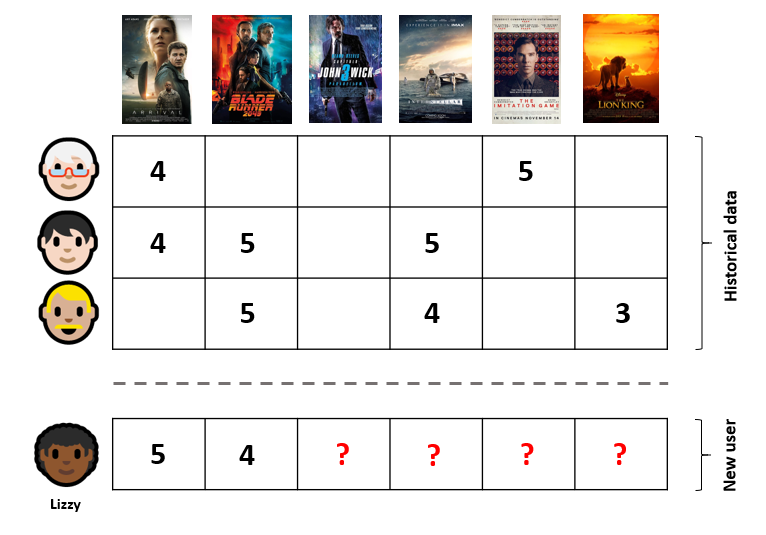

In [32]:
from IPython.display import Image, display
display(Image('/content/sample_data/collab_filtering.png'))

The main idea behind collaborative filtering methods, is to find users who liked these movies and recommend unseen movies based on their preferences. In this example, the model would likely find that other users who enjoyed these movies also liked "Interstellar", which would possibly be a nice recommendation for Lizzy.

While this is the main idea, there are many approaches to this problem and choosing the right one will mostly depend  on the size of the dataset we're working with and its sparsity.

### Types of Collaborative filtering

There are many collaborative filtering (CF in short) methods, bellow are the main types we can find:
Memory-based

* **Memory-based**

Memory-based methods use user rating historical data to compute the similarity between users or items. The idea behind these methods is to define a similarity measure between users or items, and find the most similar to recommend unseen items.
Model-based

* **Model-based**

Model-based CF uses machine learning algorithms to predict users' rating of unrated items. There are many model-based CF algorithms, the most commonly used are matrix factorization models such as to applying a SVD to reconstruct the rating matrix, latent Dirichlet allocation or Markov decision process based models.

* **Hybrid**

These aim to combine the memory-based and the model-based methods. One of the main drawbacks of the above methods, is that you'll find yourself having to choose between : user historical data and user or item attributes. Hybrid methods enable us to leverage both, and hence tend to perform better in most cases. The most widely used methods nowadays are factorization machines.

### Memory based collaborative filtering

Memory-based CF
There are 2 main types of memory-based collaborative filtering algorithms: User-Based and Item-Based. While their difference is subtle, it can sometimes be a bit confusing to know when one or the other should be used.

In this post, we'll be implementing both, but first of all let's go through a quick overview of these methods:

* **User-Based Collaborative Filtering:**

Here we find users that have seen/rated similar content, and use their preferences to recommend new items.

A drawback is there tends to be many more users than items, which leads to much bigger user similarity matrices this might be clear in the following section), leading to performance and memory issues on larger datasets, which forces to rely on parallelisation techniques or other approaches altogether.

Another common problem is that we'll suffer from a cold-start: There may be no to little information on a new user's preferences, hence nothing to compare with.

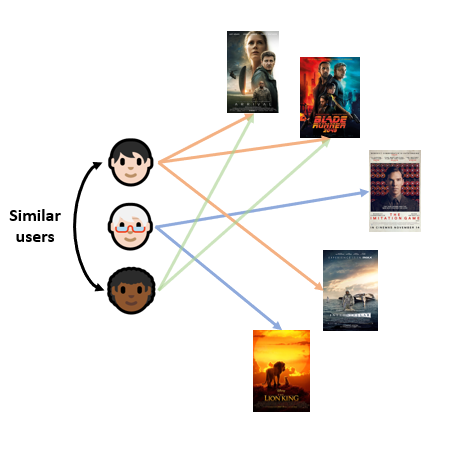

In [33]:
display(Image('/content/sample_data/user_based.png'))

* **Item-Based Collaborative Filtering:**

The idea is similar, but instead, starting from a given movie (or set of movies) we find similar movies based on users' preferences.

Contrarily to user-based methods, item similarity matrices tend to be smaller, which will reduce the cost of finding neighbours in our similarity matrix.
Also, since a single item is enough to recommend other similar items, this method will not suffer from the cold-start problem.

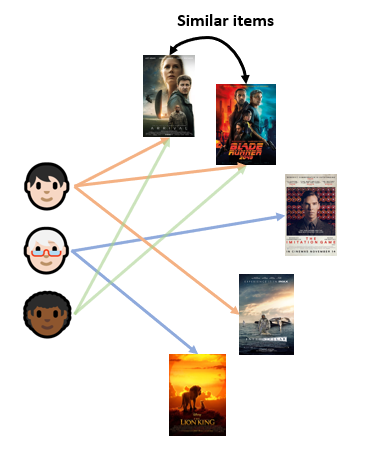

In [34]:
display(Image('/content/sample_data/item_based.png'))

## Implementation

The data
We'll be using the same dataset as in the previous post, the MovieLens dataset, which contains rating data sets from the MovieLens web site. It contains on 1M anonymous ratings of approximately 4000 movies made by 6000 MovieLens users, released in 2/2003.

We'll be working with three .csv files: ratings, users, and movies. Please check the [previous post](https://towardsdatascience.com/content-based-recommender-systems-28a1dbd858f5) for more details on the dataset.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns

In [36]:
ratings = pd.read_csv('/content/sample_data/ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])
users = pd.read_csv('/content/sample_data/users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])
movies = pd.read_csv('/content/sample_data/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

In [37]:
ratings.shape

(1000209, 3)

In [38]:
ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


### User-item matrix

The first thing we'll need to do, is to create the user-item matrix. This is essentially a pivoted table from the rating data, where the rows will be the users, the columns will be the movies and the dataframe is filled with the rating the user has given (if it exists , 0 otherwise):

In [39]:
# Use keyword arguments for pivot
user_item_m = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
print(f'Shape: {user_item_m.shape}')

Shape: (6040, 3706)


In [40]:
user_item_m.iloc[:10,:15].astype('i1').T.join(movies.set_index('movie_id').title).set_index('title').T.rename_axis('user_id')

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),"American President, The (1995)",Dracula: Dead and Loving It (1995),Balto (1995),Nixon (1995),Cutthroat Island (1995)
user_id,,,,,,,,,,,,,,,
1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
6,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
8,4,0,0,3,0,0,0,0,0,0,0,0,0,4,0
9,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Similarity matrix

Next, we will define a similarity matrix. Along  the lines of the previous post on Content based recommenders, see the section Similarity between vectors, we want to find a proximity measure between all users (or items) in the user-item matrix. A commonly used measure is the cosine similarity.

As we also saw, this similarity measure owns its name to the fact that it equals to the cosine of the angle between the two vectors being compared, user (or item) similarity vectors of scores in this case. The lower the angle between two vectors, the higher the cosine will be, hence yielding a higher similarity factor. See the aforementioned section for more details on this.
We can use sklearn's metrics.pairwise sub-module for pairwise distance or similarity metrics, in this case we'll be using cosine_similarity .

Note that the function, has the signature:

`sklearn.metrics.pairwise.cosine_similarity(X, Y=None, dense_output=True)`

Where `Y` is expected to be:

**`Y`: ndarray or sparse array, shape: (n_samples_Y, n_features). If None, the output will be the pairwise similarities between all samples in X.**

So by only specifying X this will generate a similarity matrix from the samples in X :

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

In [42]:
X_user = cosine_similarity(user_item_m)

In [43]:
X_user.shape

(6040, 6040)

In [44]:
X_user[:10,:8].round(3)

array([[1.   , 0.096, 0.121, 0.132, 0.09 , 0.179, 0.06 , 0.138],
       [0.096, 1.   , 0.151, 0.171, 0.114, 0.101, 0.306, 0.203],
       [0.121, 0.151, 1.   , 0.151, 0.063, 0.075, 0.138, 0.078],
       [0.132, 0.171, 0.151, 1.   , 0.045, 0.014, 0.13 , 0.101],
       [0.09 , 0.114, 0.063, 0.045, 1.   , 0.047, 0.126, 0.221],
       [0.179, 0.101, 0.075, 0.014, 0.047, 1.   , 0.05 , 0.075],
       [0.06 , 0.306, 0.138, 0.13 , 0.126, 0.05 , 1.   , 0.238],
       [0.138, 0.203, 0.078, 0.101, 0.221, 0.075, 0.238, 1.   ],
       [0.226, 0.19 , 0.126, 0.094, 0.261, 0.111, 0.162, 0.291],
       [0.255, 0.227, 0.214, 0.121, 0.117, 0.205, 0.093, 0.154]])

This will generate a user similarity matrix, with shape `(n_users, n_users)`.

And since `X` is expected to be:
    
**`X`: ndarray or sparse array, shape: (n_samples_X, n_features)**

By transposing the user-item matrix, our samples will now be the columns of the matrix. So if our original user-item is of shape (n,m) , by finding the cosine similarities on the transposed matrix we'll end up with a (m,m) matrix:


In [45]:
X_item = cosine_similarity(user_item_m.T)

In [46]:
X_item.shape

(3706, 3706)

In [47]:
X_item[:10,:11].round(2)

array([[1.  , 0.39, 0.27, 0.18, 0.26, 0.35, 0.3 , 0.13, 0.11, 0.38, 0.42],
       [0.39, 1.  , 0.24, 0.16, 0.25, 0.24, 0.26, 0.2 , 0.16, 0.39, 0.28],
       [0.27, 0.24, 1.  , 0.19, 0.31, 0.19, 0.29, 0.09, 0.13, 0.25, 0.29],
       [0.18, 0.16, 0.19, 1.  , 0.27, 0.13, 0.22, 0.05, 0.06, 0.13, 0.24],
       [0.26, 0.25, 0.31, 0.27, 1.  , 0.15, 0.31, 0.1 , 0.14, 0.24, 0.31],
       [0.35, 0.24, 0.19, 0.13, 0.15, 1.  , 0.18, 0.06, 0.17, 0.42, 0.28],
       [0.3 , 0.26, 0.29, 0.22, 0.31, 0.18, 1.  , 0.05, 0.08, 0.25, 0.44],
       [0.13, 0.2 , 0.09, 0.05, 0.1 , 0.06, 0.05, 1.  , 0.05, 0.11, 0.07],
       [0.11, 0.16, 0.13, 0.06, 0.14, 0.17, 0.08, 0.05, 1.  , 0.22, 0.13],
       [0.38, 0.39, 0.25, 0.13, 0.24, 0.42, 0.25, 0.11, 0.22, 1.  , 0.31]])

### The algorithm

Having created the similarity matrices, we can now define some logic to find similar users. In the case of a user-based recommendation we want to find similar users to a new user to who we want to recommend movies, and since we already have the similarity scores, we only have to search for the highest values in a given row.

Of course in this case it is simpler, since we already have computed the similarity matrix between all users. In a real scenario, we'd have to update the similarity matrix with the new user, and then find the most similar users.

Bellow is a function to implement a user-based CF recommender explained step by step:

In [48]:
def movie_recommender(user_item_m, X_user, user, k=20, top_n=10):
    # Get location of the actual movie in the User-Items matrix
    user_ix = user_item_m.index.get_loc(user)
    # Use it to index the User similarity matrix
    user_similarities = X_user[user_ix]
    # obtain the indices of the top k most similar users
    most_similar_users = user_item_m.index[user_similarities.argpartition(-k)[-k:]]
    # Obtain the mean ratings of those users for all movies
    rec_movies = user_item_m.loc[most_similar_users].mean(0).sort_values(ascending=False)
    # Discard already seen movies
    m_seen_movies = user_item_m.loc[user].gt(0)
    seen_movies = m_seen_movies.index[m_seen_movies].tolist()
    rec_movies = rec_movies.drop(seen_movies).head(top_n)
    # return recommendations - top similar users rated movies
    return rec_movies.index.to_frame().reset_index(drop=True).merge(movies)

As mentioned earlier, the difference in implementation between user and item-based CF systems is quite subtle. For this reason it might be a good idea to wrap both methods in a class, which once instantiated we'll then use to recommend movies or items to a given user:

In [49]:
class CfRec():
    def __init__(self, M, X, items, k=20, top_n=10):
        self.X = X
        self.M = M
        self.k = k
        self.top_n = top_n
        self.items = items

    def recommend_user_based(self, user):
        ix = self.M.index.get_loc(user)
        # Use it to index the User similarity matrix
        u_sim = self.X[ix]
        # obtain the indices of the top k most similar users
        most_similar = self.M.index[u_sim.argpartition(-(self.k+1))[-(self.k+1):]]
        # Obtain the mean ratings of those users for all movies
        rec_items = self.M.loc[most_similar].mean(0).sort_values(ascending=False)
        # Discard already seen movies
        # already seen movies
        seen_mask = self.M.loc[user].gt(0)
        seen = seen_mask.index[seen_mask].tolist()
        rec_items = rec_items.drop(seen).head(self.top_n)
        # return recommendations - top similar users rated movies
        return (rec_items.index.to_frame()
                                .reset_index(drop=True)
                                .merge(self.items))

    def recommend_item_based(self, item):
        liked = self.items.loc[self.items.movie_id.eq(item), 'title'].item()
        print(f"Because you liked {liked}, we'd recommend you to watch:")
        # get index of movie
        ix = self.M.columns.get_loc(item)
        # Use it to index the User similarity matrix
        i_sim = self.X[ix]
        # obtain the indices of the top k most similar users
        most_similar = self.M.columns[i_sim.argpartition(-(self.k+1))[-(self.k+1):]]
        return (most_similar.difference([item])
                                 .to_frame()
                                 .reset_index(drop=True)
                                 .merge(self.items)
                                 .head(self.top_n))

Before testing the recommender on some examples, it might be useful to define a function to see which are the preferences of a user to see if the recommendations make sense or not . Here I'm sorting the ratings given to the movies seen by a user and taking the first 10:

In [50]:
def because_user_liked(user_item_m, movies, ratings, user):
    ix_user_seen = user_item_m.loc[user]>0.
    seen_by_user = user_item_m.columns[ix_user_seen]
    return (seen_by_user.to_frame()
                 .reset_index(drop=True)
                 .merge(movies)
                 .assign(user_id=user)
                 .merge(ratings[ratings.user_id.eq(user)])
                 .sort_values('rating', ascending=False).head(10))

## Testing the recommender
Testing a recommender may be tougher than it seems. In the movielens dataset, most of the users will have seen a bit of everything, in the sense that they will probably have given a high rating to movies from multiple genres, not just their favourite.

A useful way, is to find some specific examples of users with specific tastes, for instance, with a clear preference for one or two genres. What I have done is to find users which have seen quite a few movies, but from very few genres, meaning that they clearly have a preference for those. The recommender is hence expected to suggest movies from the same genre.
Let's start with some user based recommendations:

Let's try with a user which seems to have a preference for romance and drama:

* Let's start with some **user based** recommendations:

In [51]:
rec = CfRec(user_item_m, X_user, movies)

We can see that the movies that have been most highly rated by this user, are Drama movies. Let's see what the recommender suggests:

In [52]:
because_user_liked(user_item_m, movies, ratings, 69)

,movie_id,title,genres,user_id,rating
0,14,Nixon (1995),Drama,69,5
27,1041,Secrets & Lies (1996),Drama,69,5
20,515,"Remains of the Day, The (1993)",Drama,69,5
48,1810,Primary Colors (1998),Drama,69,5
45,1747,Wag the Dog (1997),Comedy|Drama,69,5
24,593,"Silence of the Lambs, The (1991)",Drama|Thriller,69,5
25,617,"Flower of My Secret, The (La Flor de Mi Secret...",Drama,69,5
26,866,Bound (1996),Crime|Drama|Romance|Thriller,69,5
28,1095,Glengarry Glen Ross (1992),Drama,69,5
53,2336,Elizabeth (1998),Drama,69,5


In [53]:
rec.recommend_user_based(69)

,movie_id,title,genres
0,527,Schindler's List (1993),Drama|War
1,318,"Shawshank Redemption, The (1994)",Drama
2,608,Fargo (1996),Crime|Drama|Thriller
3,1213,GoodFellas (1990),Crime|Drama
4,150,Apollo 13 (1995),Drama
5,1094,"Crying Game, The (1992)",Drama|Romance|War
6,1179,"Grifters, The (1990)",Crime|Drama|Film-Noir
7,36,Dead Man Walking (1995),Drama
8,2333,Gods and Monsters (1998),Drama
9,3100,"River Runs Through It, A (1992)",Drama


The recommendations seem good! Hard to tell whether the user would completely agree with the specific movies, but the genre preferences of the user is clearly reflected in the recommendations.
Let's try with a fan of Horror movies now:

In [54]:
because_user_liked(user_item_m, movies, ratings, 2155)

,movie_id,title,genres,user_id,rating
0,12,Dracula: Dead and Loving It (1995),Comedy|Horror,2155,5
51,2548,"Rage: Carrie 2, The (1999)",Horror,2155,5
33,1999,"Exorcist III, The (1990)",Horror,2155,5
36,2026,Disturbing Behavior (1998),Horror|Thriller,2155,5
37,2120,Needful Things (1993),Drama|Horror,2155,5
38,2148,House (1986),Comedy|Horror,2155,5
39,2279,Urban Legend (1998),Horror|Thriller,2155,5
41,2328,Vampires (1998),Horror,2155,5
42,2389,Psycho (1998),Crime|Horror|Thriller,2155,5
45,2459,"Texas Chainsaw Massacre, The (1974)",Horror,2155,5


In [55]:
rec.recommend_user_based(2155)

,movie_id,title,genres
0,1339,Bram Stoker's Dracula (1992),Horror|Romance
1,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller
2,3499,Misery (1990),Horror
3,1258,"Shining, The (1980)",Horror
4,3081,Sleepy Hollow (1999),Horror|Romance
5,1982,Halloween (1978),Horror
6,1350,"Omen, The (1976)",Horror
7,2160,Rosemary's Baby (1968),Horror|Thriller
8,1387,Jaws (1975),Action|Horror
9,1215,Army of Darkness (1993),Action|Adventure|Comedy|Horror|Sci-Fi


* Let's try now with some **item based** recommendations

In [56]:
rec = CfRec(user_item_m, X_item, movies)

In [57]:
rec.recommend_item_based(2021)

Because you liked Dune (1984), we'd recommend you to watch:


,movie_id,title,genres
0,541,Blade Runner (1982),Film-Noir|Sci-Fi
1,1200,Aliens (1986),Action|Sci-Fi|Thriller|War
2,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller
3,1371,Star Trek: The Motion Picture (1979),Action|Adventure|Sci-Fi
4,1374,Star Trek: The Wrath of Khan (1982),Action|Adventure|Sci-Fi
5,1375,Star Trek III: The Search for Spock (1984),Action|Adventure|Sci-Fi
6,1376,Star Trek IV: The Voyage Home (1986),Action|Adventure|Sci-Fi
7,1527,"Fifth Element, The (1997)",Action|Sci-Fi
8,2011,Back to the Future Part II (1989),Comedy|Sci-Fi
9,2105,Tron (1982),Action|Adventure|Fantasy|Sci-Fi


In [58]:
rec.recommend_item_based(47)

Because you liked Seven (Se7en) (1995), we'd recommend you to watch:


,movie_id,title,genres
0,6,Heat (1995),Action|Crime|Thriller
1,16,Casino (1995),Drama|Thriller
2,32,Twelve Monkeys (1995),Drama|Sci-Fi
3,50,"Usual Suspects, The (1995)",Crime|Thriller
4,293,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller
5,296,Pulp Fiction (1994),Crime|Drama
6,318,"Shawshank Redemption, The (1994)",Drama
7,457,"Fugitive, The (1993)",Action|Thriller
8,593,"Silence of the Lambs, The (1991)",Drama|Thriller
9,608,Fargo (1996),Crime|Drama|Thriller


In [59]:
movies[movies.title.str.contains('Se7en')]

,movie_id,title,genres
46,47,Seven (Se7en) (1995),Crime|Thriller


Or let's try with an **animation** movie:

In [60]:
rec.recommend_item_based(2018)

Because you liked Bambi (1942), we'd recommend you to watch:


,movie_id,title,genres
0,364,"Lion King, The (1994)",Animation|Children's|Musical
1,588,Aladdin (1992),Animation|Children's|Comedy|Musical
2,594,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
3,595,Beauty and the Beast (1991),Animation|Children's|Musical
4,596,Pinocchio (1940),Animation|Children's
5,1022,Cinderella (1950),Animation|Children's|Musical
6,1025,"Sword in the Stone, The (1963)",Animation|Children's
7,1029,Dumbo (1941),Animation|Children's|Musical
8,1032,Alice in Wonderland (1951),Animation|Children's|Musical
9,1033,"Fox and the Hound, The (1981)",Animation|Children's


As you can see, in both cases the collaborative filtering model seems to provide good recommendations.

There are many improvements that could be done. One of them could be to account for the fact that users can behave very differently when it comes to rating movies. Some users might rate very highly all movies, whereas other might be much more critical. This could be done by subtracting the average score from each user, we'd then have normalised score per user.

However,  this example is hopefully quite illustrative in terms of how collaborative filtering methods work. So I'd encourage you to take it as a starting point and perhaps tweak it a little or add some improvements :)

Hope you enjoyed!